## Humans of New York - Comments Gender Classification

Think about whether you need to do some pre-processing (e.g. convert categorical attributes to numerical values, do the standartization/normalization).

Now split it into training (70%), development (15%) and test (15%) sets.

What is the most appropriate evaluation metric is for your dataset (e.g. accuracy vs. F1 score).

-----

In [1]:
import seaborn as sns
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier

### Functions

In [2]:
__masculine__ = set(['actor', 'author', 'boy', 'brave', 'bachelor', 'bridegroom',
       'brother', 'conductor', 'dad', 'daddy', 'duke', 'emperor', 'father',
       'father-in-law', 'fiance', 'gentleman', 'his', 'him', 'governor',
       'grandfather', 'grandson', 'headmaster', 'heir', 'hero', 'host',
       'hunter', 'husband', 'king', 'lad', 'landlord', 'lord', 'male',
       'man', 'manager', 'masseur', 'milkman', 'monitor', 'monk',
       'murderer', 'nephew', 'papa', 'policeman', 'postman', 'postmaster',
       'priest', 'prince', 'prophet', 'proprietor', 'prosecutor',
       'protector', 'shepherd', 'sir', 'son', 'son-in-law', 'stepfather',
       'stepson', 'steward', 'sultan', 'tailor', 'testator', 'uncle',
       'usher', 'waiter', 'washerman', 'widower', 'wizard'])

In [3]:
__feminine__ = set(['actress', 'spinster', 'girl', 'bride', 'sister', 'conductress',
       'countess', 'czarina', 'mum', 'mummy', 'duchess', 'empress',
       'mother', 'mother-in-law', 'fiancee', 'lady', 'giantess', 'goddess',
       'grandmother', 'granddaughter', 'headmistress', 'heiress',
       'heroine', 'hostess', 'wife', 'queen', 'lass', 'landlady', 'lady',
       'female', 'woman', 'manageress', 'masseuse', 'mistress', 'nun',
       'mrs', 'niece', 'mama', 'policewoman', 'postwoman', 'prietess',
       'princess', 'madam', 'daughter', 'daughter-in-law', 'step-mother',
       'step-daughter', 'stewardess', 'tailoress', 'testatrix', 'aunt',
       'usherette', 'waitress', 'washerwoman', 'widow', 'witch', 'bitch',
       'jenny', 'her', 'hers', 'she', 'maid'])

In [4]:
def data_classes(messages):
    gender = []
    msgs = [re.sub(r"\b\d+\b|![:alpha:]|\d|\W|_|\b\w{1,2}\b", " ", m).lower() for m in messages]
    for msg in msgs:
        msg_bag = msg.split(' ')
        if any([True if w in __feminine__ else False for w in msg_bag]):
            gender.append(1) # F
        elif any([True if w in __masculine__ else False for w in msg_bag]):
            gender.append(0) # M
        else:
            gender.append(2) # OTHER
    return gender

In [5]:
def text_processing(messages, max_features = None):
    corpus = [re.sub(r"\b\d+\b|![:alpha:]|\d|\W|_|\b\w{1,2}\b", " ", m).lower() for m in messages]
    if max_features is not None:
        vectorizer = CountVectorizer(strip_accents = 'ascii', stop_words=['english'], max_features = max_features)
    else:
        vectorizer = CountVectorizer(strip_accents = 'ascii', stop_words=['english'])
    vcorpus = vectorizer.fit_transform(corpus)
    labels = vectorizer.get_feature_names()
    return vcorpus, labels

In [6]:
def data_processing(data,
                 vcorpus,
                 column_class = '',
                 colnames = list):
    data[colnames] = data[colnames].astype(float)
    train = scale(data[colnames].values)
    target = data[column_class].values
    train = np.column_stack((vcorpus.toarray(), train))
    return train, target

In [7]:
def svm_cross_val(clf, X, y, k=21, cv=5, C=0.01):
    svm_scores = {}
    for i in np.linspace(C, 1.0, k):
        clf = LinearSVC(C=i)
        scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        svm_scores[i] = scores.mean()
    return svm_scores

In [8]:
def plot_svm_scores(svm_score):
    x_values = np.array(list(svm_score.keys()))
    y_values = np.array(list(svm_score.values()))
    plt.figure(figsize=(12,12))
    plt.plot(x_values, y_values, marker="o", markerfacecolor="b")
    plt.plot(x_values[np.argmax(y_values)], y_values[np.argmax(y_values)], 'ro')
    plt.yticks(y_values)
    plt.show()

In [9]:
def knn_cross_val(knn, X, y, k=21,cv=5, step=1):
    knn_scores = {}
    for _k in range(1,k,step):
        knn = KNeighborsClassifier(n_neighbors = _k)
        scores = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
        knn_scores[_k] = scores.mean()
    return knn_scores

In [10]:
def plot_knn_scores(knn_scores):
    
    x_odd = np.array(list(knn_scores.keys()))[::2]
    y_odd = np.array(list(knn_scores.values()))[::2]
    x_even = np.array(list(knn_scores.keys()))[1::2]
    y_even = np.array(list(knn_scores.values()))[1::2]
    plt.figure(figsize=(12,12))
    plt.plot(x_odd, y_odd, marker="o", markerfacecolor="b")
    plt.plot(x_even, y_even, marker="s", markerfacecolor="r")
    plt.xlim(0,21)
    plt.xticks(range(0, 21, 1))
    plt.yticks(y_even)
    plt.show()

In [11]:
class KnnClassifier:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors
        
    def fit(self, X, y):
        if self.n_neighbors > X.shape[0]:
            raise ValueError('Number of neighbors greater than Training set samples')
        self._X=X
        self._y=y

    def predict(self, X):
        
        if X.shape[0] > self._X.shape[0]:
            raise ValueError('Test set size (rows) is greather than Training set.')
        if X.shape[1] != self._X.shape[1]:
            raise ValueError('Test set has different number of features (columns) than Training set.')
        
        self.pred = np.empty(shape=(X.shape[0],0),dtype = self._y.dtype)
        
        for i in range(X.shape[0]):
            _test = X[i, :]
            _euclidean = []
            _class = []
            for n in range(self._X.shape[0]):
                dist = np.sqrt(np.sum(np.square(_test - self._X[n, :])))
                _euclidean.append(dist)
                
            idx = np.argsort(_euclidean)
            
            for k in range(self.n_neighbors):
                _class.append(self._y[idx[k]])
            
            self.pred = np.append(self.pred, Counter(_class).most_common(1)[0][0])
            
        return self.pred

### Analysis

In [12]:
data = pd.read_csv("humansofnewyork.csv")
names = list(data.columns)
colnames = [names[2], names[5], names[7], names[8], names[9]]
data = data[data['message'].notnull()]

In [13]:
data = pd.read_csv("humansofnewyork.csv")
names = list(data.columns)
colnames = [names[2], names[5], names[7], names[8], names[9]]
data = data[data['message'].notnull()]

In [14]:
messages = data['message']
gender = data_classes(messages)
data['gender'] = gender
drop = data[data['gender'] == 2]
data = data.drop(drop.index)
data = data.iloc[:, [2,5,7,8,9,10]]

In [15]:
vcorpus, labels = text_processing(data['message'])
train, train_target = data_processing(data, 
                                   vcorpus, 
                                   column_class = 'gender',
                                   colnames = colnames[2:])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train, train_target, test_size = 0.3,train_size= 0.7)
#X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size = 0.5, train_size= 0.50)

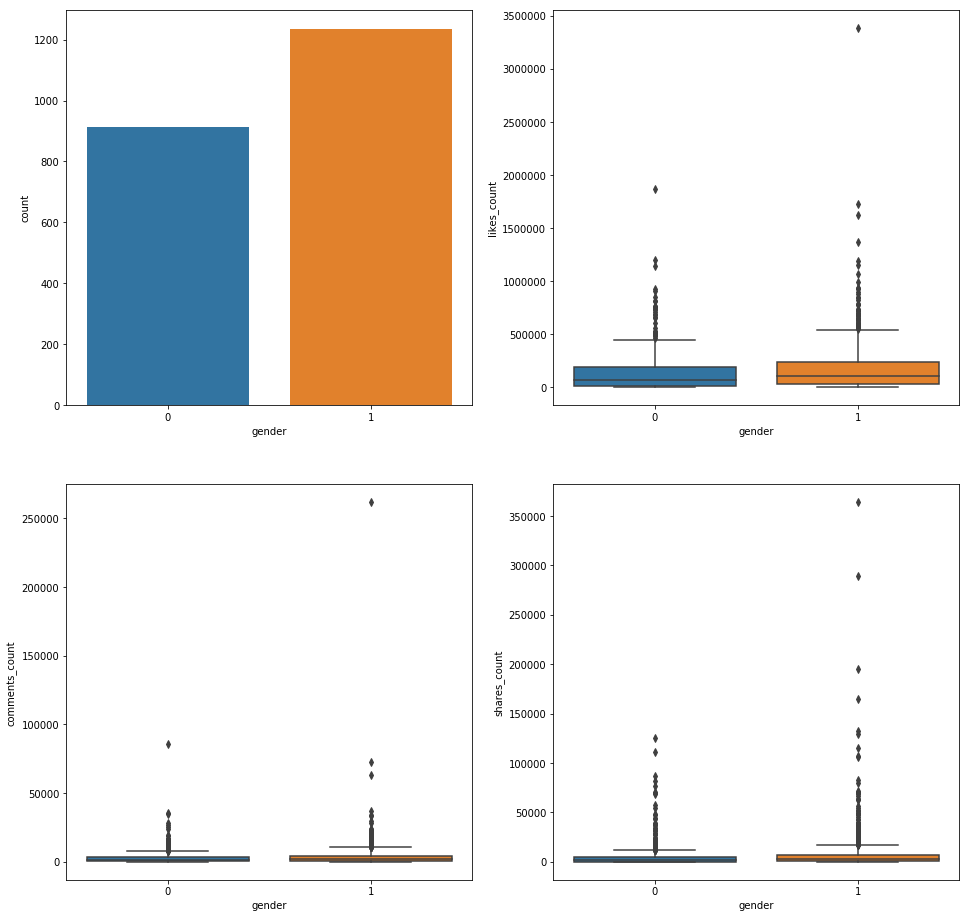

In [17]:
plt.figure(1,figsize = (16,16))
plt.subplot(221)
sns.countplot(data['gender'])
plt.subplot(222)
sns.boxplot(x = 'gender', y = 'likes_count', data = data)
plt.subplot(223)
sns.boxplot(x = 'gender', y = 'comments_count', data = data)
plt.subplot(224)
sns.boxplot(x = 'gender', y = 'shares_count', data = data)
plt.show()

### SVM implementations in scikit-learn to train a classifier. Use the default classifier parameters. Evaluate your classifier on the development set.

In [18]:
model = LinearSVC(C=1)
model.fit(X_train, y_train)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [19]:
df = pd.DataFrame(X_train).head()
df.to_csv("/Users/jlroo/Desktop/head.csv")

In [20]:
feature_selection = SelectFromModel(model, prefit=True)
X_train = feature_selection.transform(X_train)
X_test = feature_selection.transform(X_test)

In [21]:
clf = LinearSVC(C=1)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [22]:
svc_scores = svm_cross_val(clf, X_train, y_train, k=21, cv=5, C=0.01)

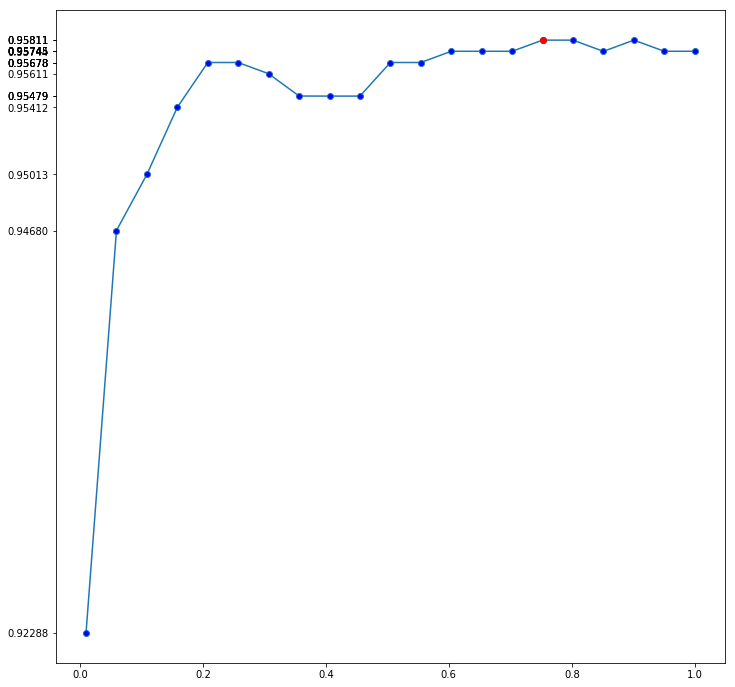

In [23]:
plot_svm_scores(svc_scores)

-----

### Now try to tweak the classifier parameters and see if you can improve your model’s performance on the development set.

-----

### Implement your own k-nearest neighbors classifier (KNN).

In [25]:
knn = KnnClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
kpred = knn.predict(X_test)

-----

### Now try to tune the $k$ value to achive the best possible performance on the development set.

In [26]:
import psutil
cores = psutil.cpu_count()
knn = KNeighborsClassifier(n_jobs=cores)
knn_scores = knn_cross_val(knn, X_train, y_train, k=21,cv=5, step=1)

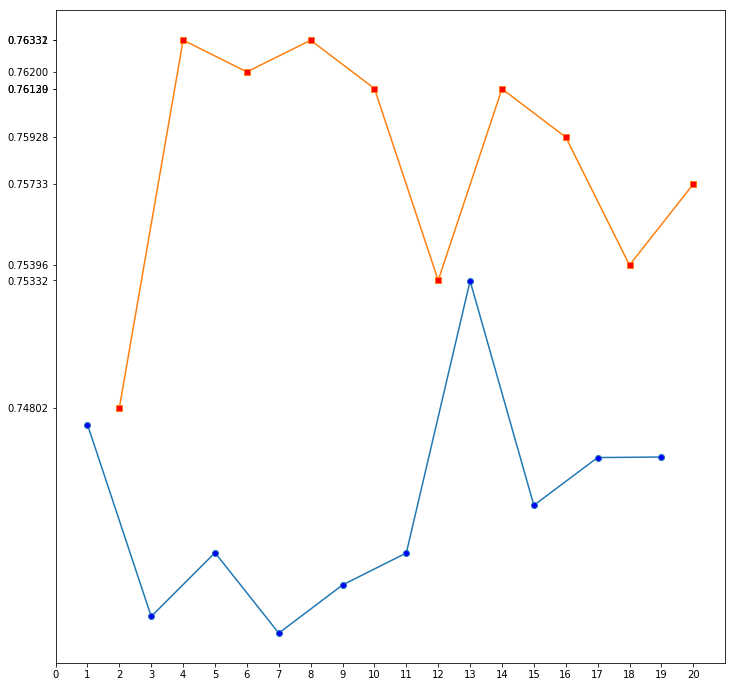

In [27]:
plot_knn_scores(knn_scores)

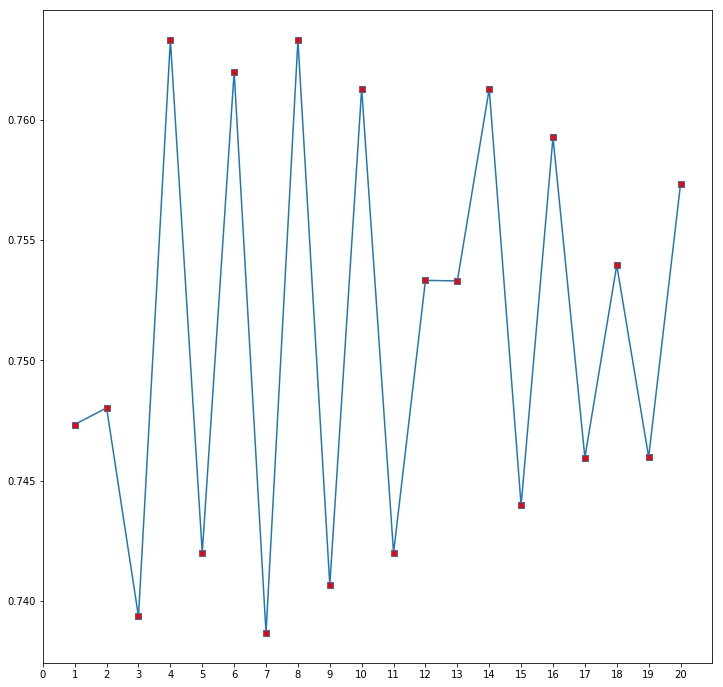

In [28]:
x = np.array(list(knn_scores.keys()))
y = np.array(list(knn_scores.values()))
plt.figure(figsize=(12,12))
plt.plot(x, y, marker="s", markerfacecolor="r")
plt.xlim(0,21)
plt.xticks(range(0, 21, 1))
plt.show()


-----

### Compare your best model you built in step (2) to your best KNN model by evaluating them on the test set.

In [32]:
svm_f1 = f1_score(y_pred = pred, y_true = y_test, average='weighted')

In [33]:
knn_f1 = f1_score(y_pred = kpred, y_true = y_test, average='weighted')

In [34]:
print("----------------- Model Evaluation -----------------")
print("f1 Score Metric - Scale (0.0, 1.0) - (WORSE, BEST)")
print("")
print("--------------- SVM Metric Evaluation --------------")
print("SVM f1 Score: " + str(svm_f1))
print("")
print("--------------- KNN Metric Evaluation --------------")
print("KNN f1 Score: " + str(knn_f1))

----------------- Model Evaluation -----------------
f1 Score Metric - Scale (0.0, 1.0) - (WORSE, BEST)

--------------- SVM Metric Evaluation --------------
SVM f1 Score: 0.944204774933

--------------- KNN Metric Evaluation --------------
KNN f1 Score: 0.729528199296
